# Master thesis - Datacentric aproach to time series forecasting 

Authors:
- Berling Gustav - gusbe498@student.liu.se
- Janzén Albin - albja295@student.liu.se

Import libraries, data and set global parameters

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
from matplotlib.patches import Rectangle
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(1234)
tf.keras.utils.set_random_seed(1234)

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

#Plot colors
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']


C:\Users\albin\AppData\Local\Temp\ipykernel_2388\2365416793.py:20: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  og_df = pd.read_csv('data/Structured/all_data.csv')


Remove empty data and change order of columns

In [7]:
#Drop all empty columns
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)


C:\Users\albin\AppData\Local\Temp\ipykernel_2388\1731155982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Summa gas/Diesel'], axis=1, inplace=True)


In [8]:
def create_dataset(data, look_back=1):
    n_features = data.shape[1]
    dataX = np.empty((len(data)-look_back-1, look_back, n_features))
    dataY = np.empty((len(data)-look_back-1))
    for i in range(len(data)-look_back-1):
        dataX[i] = data[i:i+look_back]
        dataY[i] = data[i+look_back][0]
    return dataX, dataY

def preprocess(df, method):
    import gc
    gc.collect()
    if method == 'ffill':
        #Fill missing values with the previous value
        df = df.fillna(method='ffill')
        #Fill missing values with the next value
        #df = df.fillna(method='bfill')
        # df = df.fillna(value=-1)
        df = df.fillna(df.mean())
    elif method == 'mean':
        df = df.fillna(df.mean())
    elif method == 'negative':
        df = df.fillna(value=-1)
    elif method == 'fbfill':
        df = df.fillna(method='ffill')
        df = df.fillna(method='bfill')
    elif method == 'mask':
        df = df.fillna(value=-1)
    elif method == 'zero':
        df = df.fillna(value=0)
    elif method == 'interpolate':
        df = df.interpolate(method='linear', axis=0)
        df = df.fillna(value=-1)
    
    #Remove collumns with only one value
    for e in df.columns:
        if df[e].nunique() == 1:
            df = df.drop(e, axis=1)

    #Change index of target variable  
    first_column = df.pop('SE1')
    df.insert(1, 'SE1', first_column)

    #Set date for end of test data
    test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]

    #Remove dates from dataframe
    dates = df.pop('Date')
    years = [year.split("-")[0] for year in dates]

    #Save number of features
    n_original_features = df.shape[1]
    print(n_original_features)


    # Normalize the features using MinMaxScaler
    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])

    if method == 'negative_after':
        df = df.fillna(value=-1)
    # Fit PCA to identify which features contribute the most to variance
    pca = PCA()
    pca.fit(df)

    n_used_features = 15

    # Get explained variance ratios of each principal component
    variance_ratios = pca.explained_variance_ratio_

    # Sort features by their explained variance ratios and select the top 20
    top_n_features_idx = variance_ratios.argsort()[::-1][:n_used_features]
    top_n_features = df.columns[top_n_features_idx]

    # Select only the top 20 features from the original data
    data_top_n = df[top_n_features]
    df = data_top_n
    n_features = n_used_features
    colorpicker = plt.cm.jet(np.linspace(0,1,n_features))

    # Split the dataset into training and testing sets
    test_size = int(len(df) * 0.05)
    val_size = int(len(df) * 0.1)
    val_end = test_end - test_size

    train_df = df[:val_end-val_size]
    train_dates = dates[:val_end-val_size]

    val_df = df[val_end-val_size:val_end]
    val_dates = dates[val_end-val_size:val_end]

    test_df = df[test_end-test_size:test_end]
    test_dates = dates[test_end-test_size:test_end]

    train_df = pd.concat([train_df, df[test_end:]])
    train_dates = pd.concat([train_dates, dates[test_end:]])

    look_back = 3
    X_train, y_train = create_dataset(train_df.values, look_back)
    X_val, y_val = create_dataset(val_df.values, look_back)
    X_test, y_test = create_dataset(test_df.values, look_back)


    batch_size = 128
    print(X_train.shape)
    # Calculate the number of samples that are evenly divisible by batch_size
    num_samples_train = X_train.shape[0] // batch_size * batch_size
    num_samples_val = X_val.shape[0] // batch_size * batch_size
    num_samples_test = X_test.shape[0] // batch_size * batch_size

    # Reshape the input data to have a shape that is evenly divisible by batch_size
    X_train = X_train[:num_samples_train]
    y_train = y_train[:num_samples_train]
    train_dates = train_dates[:num_samples_train]

    X_val = X_val[:num_samples_val]
    y_val = y_val[:num_samples_val]
    val_dates = val_dates[:num_samples_val]

    X_test = X_test[:num_samples_test]
    y_test = y_test[:num_samples_test]
    test_dates = test_dates[:num_samples_test]

    # Verify that the new shape is evenly divisible by batch_size
    assert X_train.shape[0] % batch_size == 0
    assert X_val.shape[0] % batch_size == 0
    assert X_test.shape[0] % batch_size == 0

    return batch_size, X_train, y_train, X_val, y_val, X_test, y_test, train_dates, val_dates, test_dates, n_features, n_original_features, colorpicker

Adapt the data to the batching

Create the LSTM model

In [9]:
def create_model(batch_size, n_features):
    # Define the model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
        tf.keras.layers.Dense(1)
    ])  
    return model

Class for plotting the learning process, used as a callback for the compile function of the model

In [10]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color=colors[0])
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color=colors[3])
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

Compile and fit the model: train the model

In [11]:
def compile_and_fit(model, X_train, y_train, X_val, y_val, batch_size, patience=10):
  tf.keras.backend.clear_session()
  model.reset_states()
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    restore_best_weights=True,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.build(X_train.shape)
  print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping,PlotLearning()])
  return history

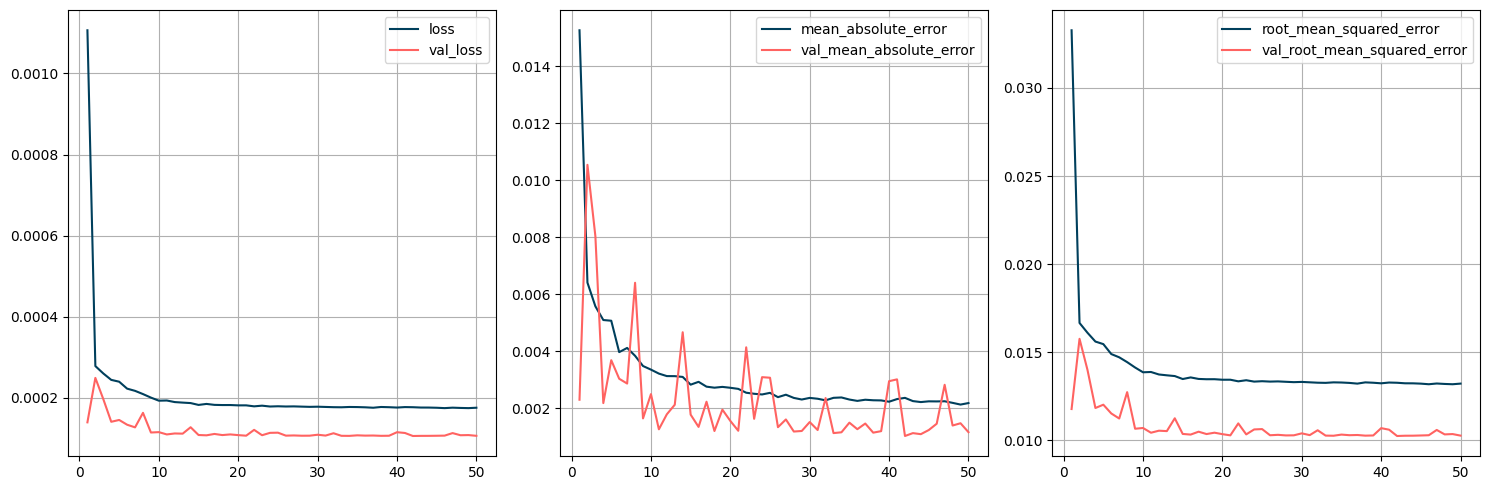

1347/1347 [==============================] - 8s 6ms/step - loss: 1.7485e-04 - mean_absolute_error: 0.0022 - root_mean_squared_error: 0.0132 - val_loss: 1.0552e-04 - val_mean_absolute_error: 0.0012 - val_root_mean_squared_error: 0.0103


In [12]:
methods = ['ffill', 'fbfill', 'mean', 'zero', 'negative', 'interpolate', 'negative_after']
metrics = []
for method in methods:
    batch_size, X_train, y_train, X_val, y_val, X_test, y_test, train_dates, val_dates, test_dates, n_features, n_original_features, colorpicker = preprocess(df, method)
    model = create_model(batch_size, n_features)
    history = compile_and_fit(model, X_train, y_train, X_val, y_val, batch_size)
    metrics.append(np.min(history.history['val_mean_absolute_error']))

In [13]:
print(metrics)

[0.001297270180657506, 0.0009108994854614139, 0.0008412645547650754, 0.0008616005070507526, 0.0007692776853218675, 0.0012286151759326458, 0.0010288743069395423]


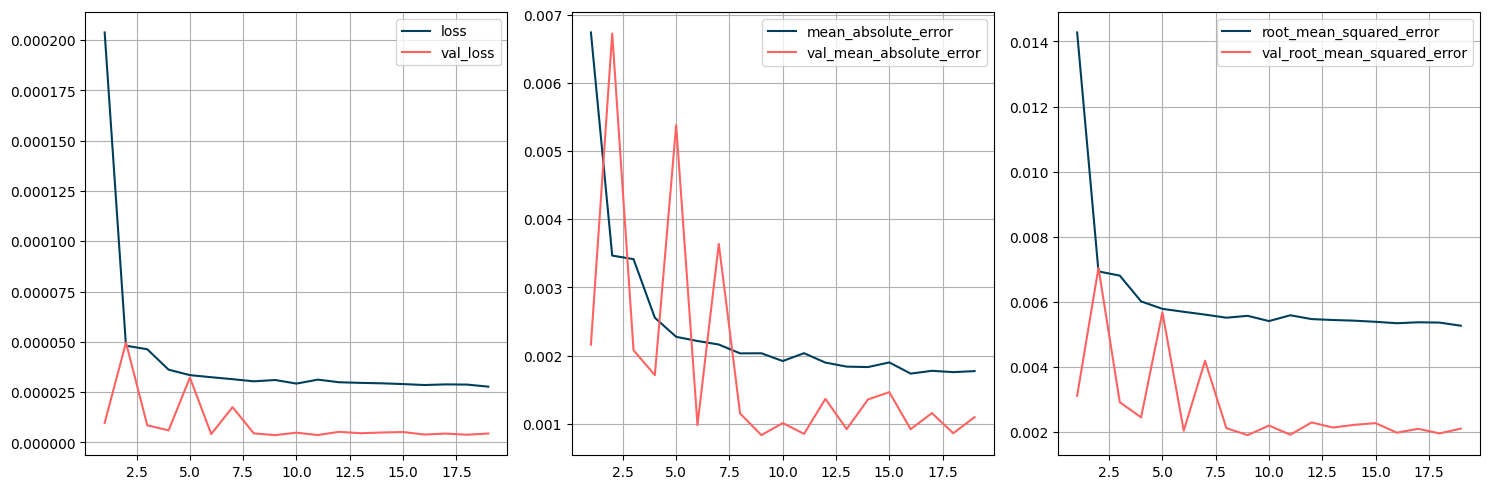

1347/1347 [==============================] - 10s 8ms/step - loss: 2.7740e-05 - mean_absolute_error: 0.0018 - root_mean_squared_error: 0.0053 - val_loss: 4.4358e-06 - val_mean_absolute_error: 0.0011 - val_root_mean_squared_error: 0.0021
0.0008325842791236937


In [14]:
batch_size, X_train, y_train, X_val, y_val, X_test, y_test, train_dates, val_dates, test_dates, n_features, n_original_features, colorpicker = preprocess(df, 'mask')
# Define the model architecture
mask_model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=-1, batch_input_shape=(batch_size, None, n_features)),
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
    tf.keras.layers.Dense(1)
])  
history = compile_and_fit(mask_model, X_train, y_train, X_val, y_val, batch_size)
print(np.min(history.history['val_mean_absolute_error']))